# Clustering graph into k definite subsets
<img src="image.png">
 


## Graph reader and Graph classes
**We are going to define graph classes to read any input graph**

In [1]:
# Graph class

import numpy as np

class Node:
    def __init__(self, id):
        self.id = id

    def get_id(self):
        return self.id
    
class Edge:
    def __init__(self, source, dest):
        self.source = source
        self.dest = dest

class Graph:

    def __init__(self, num_of_nodes):
        self.num_of_nodes = num_of_nodes
        self.nodes = []
        self.edges = []
        for i in range(num_of_nodes):
            self.nodes.append(Node(i))
        self.adjacent_list = [[] for i in range(num_of_nodes)]
        self.adjacent_list_transpose = [[] for i in range(num_of_nodes)]

    def get_node(self, id):
        """
        :param id:
        :return: The object Node with the given id
        """
        return self.nodes[id]

    def add_edge(self, edge):
        self.edges.append(edge)
        self.adjacent_list[edge.source.id].append(edge.dest)
        self.adjacent_list_transpose[edge.dest.id].append(edge.source)

    def get_adjacent_nodes(self, node):
        return self.adjacent_list[node.id]

    def get_adjacent_nodes_transpose(self, node):
        return self.adjacent_list_transpose[node.id]
    
    def get_D_matrix(self):
        # sum row-wise elements of Adjacency matrix
        D = np.zeros((len(self.nodes), len(self.nodes)))
        
        for i in range(len(self.nodes)):
            D[i][i] = len(self.get_adjacent_nodes(Node(i)))
            
        return D
    
    def get_A_matrix(self):
        A = np.zeros((len(self.nodes), len(self.nodes)))
        
        for node in self.nodes:
            for neigh in self.get_adjacent_nodes(node):
                A[node.id][neigh.id] = 1
            
        return A


In [2]:
# Graph Reader 

class GraphReader():
    def __init__(self, path, is_undirected=False):
        self.path = path
        self.is_undirected = is_undirected
        self.dict_inv = {}

    def read_graph(self):
        """
        Dataset is in txt each line is in the format "id_src, id_dst"
        :return:
        """
        filename = self.path
        edges = []
        with open(filename) as f:
            for line in f:
                edges.append([int(n) for n in line.strip().split(",")[:2]])

        nodes = []
        for e in edges:
            nodes.append(e[0])
            nodes.append(e[1])

        nodes = list(set(nodes))
        
        # Create mapping with ids from 0 to len(set(nodes)) -1
        new_id = 0
        dict_nodes_id = {}
        for el in list(set(nodes)):
            dict_nodes_id[el] = new_id
            self.dict_inv[new_id] = el
            new_id+=1

        myGraph = Graph(len(nodes))
        for el in edges:#[:-1]:
            curr_edge = Edge(Node(dict_nodes_id[el[0]]), Node(dict_nodes_id[el[1]]))
            myGraph.add_edge(curr_edge)

            if self.is_undirected:
                curr_edge_inv = Edge(Node(dict_nodes_id[el[1]]), Node(dict_nodes_id[el[0]]))
                myGraph.add_edge(curr_edge_inv)

        return myGraph



# Import data and start the analysis
**We will sequentially perform the analysis for the 2 given graphs in the files**
- example1.txt (1966, data collected by Coleman, Katz and Menzel on medical innovation)
- example2.txt (synthetic graph)

In [18]:
path = "example1.txt"
graph_reader = GraphReader(path)
graph = graph_reader.read_graph()

In [19]:
import numpy as np
from sklearn.preprocessing import normalize

# Defining parameters
noise = 1
A = graph.get_A_matrix()
D = graph.get_D_matrix()
X = normalize(A, norm='l1')

## Adjacency and Diagram matrices (A and D)
**That's how they look like for us:**

In [20]:
print("A",A)
print("D",D)

A [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
D [[ 7.  0.  0. ...  0.  0.  0.]
 [ 0.  9.  0. ...  0.  0.  0.]
 [ 0.  0. 11. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2.  0.  0.]
 [ 0.  0.  0. ...  0.  8.  0.]
 [ 0.  0.  0. ...  0.  0.  2.]]


In [21]:
from numpy.linalg import matrix_power
D_1_2 = D.copy()
for i in range(len(D)):
    D_1_2[i][i] = D_1_2[i][i]**(-0.5)
print(D_1_2)

[[0.37796447 0.         0.         ... 0.         0.         0.        ]
 [0.         0.33333333 0.         ... 0.         0.         0.        ]
 [0.         0.         0.30151134 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.70710678 0.         0.        ]
 [0.         0.         0.         ... 0.         0.35355339 0.        ]
 [0.         0.         0.         ... 0.         0.         0.70710678]]


In [22]:
# Our laplacian as D^-0.5 dot A dot D^-0.5
L_temp = np.dot(D_1_2, A)
L = np.dot(L_temp, D_1_2)
print(L)

[[0.         0.12598816 0.11396058 ... 0.         0.         0.        ]
 [0.12598816 0.         0.         ... 0.         0.         0.        ]
 [0.11396058 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [23]:
# Eigenpair
from numpy import linalg as LA
eigenval, eigenvect = LA.eig(L)
eigenpairs = [(eigenval[i], eigenvect[i]) for i in range(len(eigenval))]

eigenpairs.sort(key=lambda x: x[0])
eigenpairs = eigenpairs[::-1]

print("Biggest 10 eigenvalues are", [x[0] for x in eigenpairs[:10]])

Biggest 10 eigenvalues are [0.8723206270848811, 0.8629824614668324, 0.8417462379135243, 0.8128642612429733, 0.77264180889328, 0.6875489381479976, 0.6621975278394522, 0.6554126722738264, 0.645394362428307, 0.6397006265754791]


In [24]:
# Find the k value by maximizing the eigengap:
def find_best_k(eigenvals):
    k = 0
    gap = 0
    for i in range(len(eigenvals)-1):
        curr_gap = eigenvals[i]-eigenvals[i+1]
        if curr_gap > gap:
            k = i
            gap = curr_gap
    return k

## Graph spectra: we are going to print the eigenvalues sorted

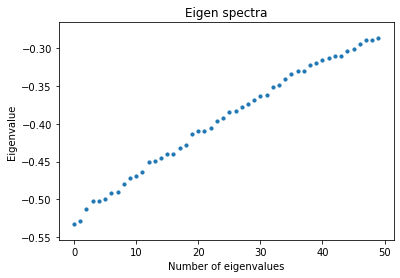

In [25]:
# PLOT eigenvalues
import matplotlib.pyplot as plt
# x axis value list.
x_number_list = list(range(len(eigenval)))[:50]

# y axis value list.
y_number_list = sorted(eigenval)[:50]

# Draw point based on above x, y axis values.
plt.scatter(x_number_list, y_number_list, s=10)

# Set chart title.
plt.title("Eigen spectra")

# Set x, y label text.
plt.xlabel("Number of eigenvalues")
plt.ylabel("Eigenvalue")
plt.show()

In [26]:
# get matrix X of largest k eigenvalues' eigenvectors
from operator import itemgetter

k = find_best_k(list(map(itemgetter(0), eigenpairs)))
print("Best found k is", k)
X = eigenvect[:,:k]
Y = X#normalize(X, norm='l2')

Best found k is 9


In [27]:
# K-means
from sklearn.cluster import KMeans
import numpy as np

n_clusters = k
kmeans = KMeans(n_clusters=n_clusters , random_state=0).fit(Y)
kmeans.labels_

array([7, 4, 4, 6, 2, 0, 4, 3, 2, 2, 2, 2, 5, 5, 5, 8, 8, 5, 5, 1, 1, 5,
       8, 0, 1, 5, 5, 5, 6, 8, 8, 8, 8, 5, 8, 8, 0, 3, 3, 2, 2, 3, 5, 8,
       8, 8, 5, 5, 0, 2, 6, 8, 3, 8, 5, 3, 0, 4, 8, 6, 0, 8, 5, 5, 5, 3,
       2, 5, 3, 0, 0, 4, 5, 8, 3, 5, 2, 2, 5, 5, 8, 2, 4, 5, 3, 8, 5, 3,
       4, 2, 3, 5, 5, 4, 1, 5, 8, 2, 3, 5, 2, 7, 4, 5, 5, 5, 0, 0, 5, 3,
       0, 2, 8, 8, 5, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

### Print the found clusters

In [28]:
nodes_with_clusters = kmeans.predict(Y)

clusters = [[] for i in range(n_clusters )]
for i in range(len(nodes_with_clusters)):
    clusters[nodes_with_clusters[i]].append(graph_reader.dict_inv[i])
print(clusters)

[[6, 24, 37, 49, 57, 61, 70, 71, 107, 108, 111, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241], [20, 21, 25, 95, 117], [5, 9, 10, 11, 12, 40, 41, 50, 67, 77, 78, 82, 90, 98, 101, 112], [8, 38, 39, 42, 53, 56, 66, 69, 75, 85, 88, 91, 99, 110], [2, 3, 7, 58, 72, 83, 89, 94, 103], [13, 14, 15, 18, 19, 22, 26, 27, 28, 34, 43, 47, 48, 55, 63, 64, 65, 68, 73, 76, 79, 80, 84, 87, 92, 93, 96, 100, 104, 105, 106, 109, 115, 116], [4,

# 2 - Graph example

In [29]:
path = "example2.txt"
graph_reader = GraphReader(path, True)
graph = graph_reader.read_graph()

[[0.         0.02528609 0.         ... 0.         0.         0.        ]
 [0.02528609 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.02378257 0.02044652 0.01706972]
 ...
 [0.         0.         0.02378257 ... 0.         0.         0.        ]
 [0.         0.         0.02044652 ... 0.         0.         0.01814885]
 [0.         0.         0.01706972 ... 0.         0.01814885 0.        ]]
Biggest 10 eigenvalues are [0.4999999999999991, 0.4172142392533188, 0.1446699561791223, 0.13532777891937947, 0.12666903212991457, 0.12456951726769366, 0.11968178821561895, 0.118301153492255, 0.11360731112534717, 0.10683127990978561]


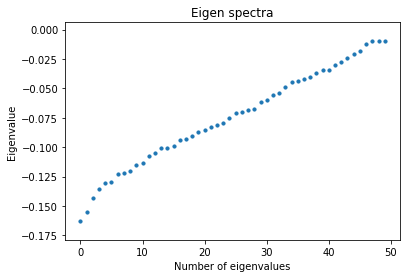

Best found k is 1


In [32]:
# Defining parameters
noise = 1
A = graph.get_A_matrix()
D = graph.get_D_matrix()
X = normalize(A, norm='l1')

D_1_2 = D.copy()
for i in range(len(D)):
    D_1_2[i][i] = D_1_2[i][i]**(-0.5)
    
# Our laplacian as D^-0.5 dot A dot D^-0.5
L_temp = np.dot(D_1_2, A)
L = np.dot(L_temp, D_1_2)
print(L)

eigenval, eigenvect = LA.eig(L)
eigenpairs = [(eigenval[i], eigenvect[i]) for i in range(len(eigenval))]

eigenpairs.sort(key=lambda x: x[0])
eigenpairs = eigenpairs[::-1]

print("Biggest 10 eigenvalues are", [x[0] for x in eigenpairs[:10]])

# x axis value list.
x_number_list = list(range(len(eigenval)))[:50]

# y axis value list.
y_number_list = sorted(eigenval)[:50]

# Draw point based on above x, y axis values.
plt.scatter(x_number_list, y_number_list, s=10)

# Set chart title.
plt.title("Eigen spectra")

# Set x, y label text.
plt.xlabel("Number of eigenvalues")
plt.ylabel("Eigenvalue")
plt.show()

k = find_best_k(list(map(itemgetter(0), eigenpairs)))
print("Best found k is", k)
X = eigenvect[:,:k]
Y = X#normalize(X, norm='l2')

The eigengap technique for detecting the best k outputs k=1, hence, the cluster seems to be well connected and doesn't detect presence of communities

In [35]:
n_clusters = k
kmeans = KMeans(n_clusters=n_clusters , random_state=0).fit(Y)
nodes_with_clusters = kmeans.predict(Y)

clusters = [[] for i in range(n_clusters )]
for i in range(len(nodes_with_clusters)):
    clusters[nodes_with_clusters[i]].append(graph_reader.dict_inv[i])
print(clusters)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]]
